In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from Farm_Evaluator_Vec import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
os.listdir('drive/My Drive/shellai')

In [5]:
def init_preprocessing(year):
    global wind_inst_freq, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t
    wind_inst_freq =  binWindResourceData('./wind_data_20{}.csv'.format(str(year).zfill(2)))
    n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)

In [6]:
'''preprocessing to compute AEP'''
turb_specs    =  {   
                     'Name': 'Anon Name',
                     'Vendor': 'Anon Vendor',
                     'Type': 'Anon Type',
                     'Dia (m)': 100,
                     'Rotor Area (m2)': 7853,
                     'Hub Height (m)': 100,
                     'Cut-in Wind Speed (m/s)': 3.5,
                     'Cut-out Wind Speed (m/s)': 25,
                     'Rated Wind Speed (m/s)': 15,
                     'Rated Power (MW)': 3
                 }
turb_diam      =  turb_specs['Dia (m)']
turb_rad       =  turb_diam/2 

# turb_coords   =  getTurbLoc(r'..\Shell_Hackathon Dataset\turbine_loc_test.csv')
power_curve   =  loadPowerCurve('./power_curve.csv')
# wind_inst_freq =  binWindResourceData('./wind_data_2007.csv')   
# n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)

years = [7,8,9,13,14,15,17]
init_preprocessing(7)

In [7]:
def AEP_simp(turb_coords,print_=0):
    # checkConstraints(turb_coords, turb_diam)
    AEP = getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
              n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
    if print_:
        print('Total power produced by the wind farm is: ', "%.12f"%(AEP), 'GWh')
    return AEP

def check_inc_violation(pts,point):
    '''check if adding new point will casue an violation'''
    x,y = point
    if x<50 or x>3950 or y<50 or y>3950:
        return 1
    for x0,y0 in pts:
        if (x0-x)**2 + (y0-y)**2 < 160000:
            return 1
    return 0

def to_csv(arr,filename='turbinesrand.csv'):
    '''convert the locations into a csv file'''
    df = pd.DataFrame(arr)
    df = df.rename(columns = {0:'x',1:'y'})
    df.to_csv(filename,index=False)
    
def plot_constraint_violations(pts):
    for i in range(len(pts)):
        x0,y0 = pts[i]
        if x0<50 or x0>3950 or y0<50 or y0>3950:
            print(x0,y0)
        for j in range(i+1,len(pts)):
            x1,y1 = pts[j]
            if (x0-x1)**2 + (y0-y1)**2 < 400**2:
                plt.plot([x0,x1],[y0,y1],'r')

def plot_turbine_locations(locs):
    '''visualize the turbine locations'''
    corners = np.array([[50,50],[50,3950],[3950,50],[3950,3950]])
    pts_list = np.vstack([locs , corners])
    x,y  =  [i[0] for i in pts_list], [i[1] for i in pts_list]
    plt.scatter(x,y)

    plot_constraint_violations(locs)
    plt.show()

In [8]:
#@title faster single move functions { form-width: "200px" }
def preAEP(turb_coords):
    n_turbs        =   turb_coords.shape[0]
    pre_rotate_coords   =  np.zeros((n_wind_instances, n_turbs, 2), dtype=np.float32)
    pre_rotate_coords[:,:,0] =  np.matmul(cos_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) - \
                           np.matmul(sin_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
    pre_rotate_coords[:,:,1] =  np.matmul(sin_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) +\
                           np.matmul(cos_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))

    pre_x_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
        tmp = pre_rotate_coords[i,:,0].repeat(n_turbs).reshape(n_turbs, n_turbs)
        pre_x_dist[i] = tmp - tmp.transpose()

    pre_y_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
        tmp = pre_rotate_coords[i,:,1].repeat(n_turbs).reshape(n_turbs, n_turbs)
        pre_y_dist[i] = tmp - tmp.transpose()
    pre_y_dist = np.abs(pre_y_dist) 

    pre_sped_deficit = (1-np.sqrt(1-C_t))*((turb_rad/(turb_rad + 0.05*pre_x_dist))**2) 
    pre_sped_deficit[((pre_x_dist <= 0) | ((pre_x_dist > 0) & (pre_y_dist > (turb_rad + 0.05*pre_x_dist))))] = 0.0
    pre_sped_deficit_sqr = np.square(pre_sped_deficit)
    
    return pre_rotate_coords, pre_x_dist, pre_y_dist, pre_sped_deficit_sqr

def AEP_fast(index,point,pre_rotate_coords, pre_x_dist, pre_y_dist, pre_sped_deficit_sqr,copy_inputs=True,ret_pre=False):
    if copy_inputs  == True:
        rotate_coords0    = pre_rotate_coords.copy()
        x_dist0           = pre_x_dist.copy()
        y_dist0           = pre_y_dist.copy()
        sped_deficit_sqr0 = pre_sped_deficit_sqr.copy()
    else:
        rotate_coords0    = pre_rotate_coords
        x_dist0           = pre_x_dist
        y_dist0           = pre_y_dist
        sped_deficit_sqr0 = pre_sped_deficit_sqr

    n_turbs = 50
    rotate_coords0[:,index,0] =  (cos_dir*point[0] - sin_dir*point[1]).ravel()
    rotate_coords0[:,index,1] =  (sin_dir*point[0] + cos_dir*point[1]).ravel()

    rotated_point = rotate_coords0[:,index]

    x_row   = rotate_coords0[:,index,0].reshape(540,1) - rotate_coords0[:,:,0]
    x_col   = - x_row
    x_dist0[:,index,:] = x_row
    x_dist0[:,:,index] = x_col
    
    y_row   = np.abs(rotate_coords0[:,index,1].reshape(540,1) - rotate_coords0[:,:,1])
    y_col   = y_row
    y_dist0[:,index,:] = y_row
    y_dist0[:,:,index] = y_row

    sped_deficit_sqr0[:,index,:] = np.square( (1-np.sqrt(1-C_t))[:,index,:]*((turb_rad/(turb_rad + 0.05*x_row))**2) )
    sped_deficit_sqr0[:,index,:][((x_row <= 0) | ((x_row > 0) & (y_row > (turb_rad + 0.05*x_row))))] = 0.0

    sped_deficit_sqr0[:,:,index] = np.square( (1-np.sqrt(1-C_t))[:,index,:]*((turb_rad/(turb_rad + 0.05*x_col))**2) )
    sped_deficit_sqr0[:,:,index][((x_col <= 0) | ((x_col > 0) & (y_col > (turb_rad + 0.05*x_col))))] = 0.0


    sped_deficit_eff0  = np.sqrt(np.sum(sped_deficit_sqr0, axis = 2))
    wind_sped_eff0     = wind_sped_stacked*(1.0-sped_deficit_eff0)

    indices = searchSorted(power_curve[:,0], wind_sped_eff0.ravel())
    power   = power_curve[indices,2]
    power   = power.reshape(n_wind_instances,n_turbs)
    power   = np.sum(power, axis=1)

    AEP = 8760.0*np.sum(power*wind_inst_freq)
    AEP = AEP/1e3
    if ret_pre:
        return AEP,pre_rotate_coords, pre_x_dist, pre_y_dist, pre_sped_deficit_sqr
    return AEP

In [87]:
def move1(turbine_coords,index=0,
          mindist=10, maxdist=4000,diststep=100,
          anglestep=36,anglemode=0):
    '''move a selected turbine to different positions and
    return the max AEP position'''
    tx,ty = turbine_coords[index]
    preprocessed = preAEP(turbine_coords)
    AEP  = AEP_fast(index,turbine_coords[index],*preprocessed,copy_inputs=False)
    init = (AEP,tx,ty)
    maxx = (0  ,tx,ty)
    for dist in range(mindist,maxdist,diststep):
        angle_step = anglestep if anglemode == 0 else int(anglestep*dist/mindist) + 1
        for drct in np.linspace(0,2*np.pi,angle_step,endpoint=False):
            dx,dy = dist*np.cos(drct), dist*np.sin(drct)
            point = [tx + dx, ty + dy]
            if check_inc_violation(turbine_coords[:index],point) or \
                check_inc_violation(turbine_coords[index+1:],point):
                continue

            turbine_coords[index][0], turbine_coords[index][1] = point
            AEP = AEP_fast(index,point,*preprocessed,copy_inputs=False)
            if AEP > maxx[0]:
                maxx = (AEP,*point)
    return maxx,init

def move_slow(turbine_coords,index=0,maxdist=4000,diststep=100,anglestep=36):
    '''move a selected turbine to different positions and
    return the max AEP position'''
    tx,ty = turbine_coords[index]
    maxx = (AEP_simp(turbine_coords),tx,ty)
    for dist in range(10,maxdist,diststep):
        #print(dist)
        for drct in np.linspace(0,2*np.pi,anglestep,endpoint=False):
            dx,dy = dist*np.cos(drct), dist*np.sin(drct)
            #print(dx,dy)
            point = [tx + dx, ty + dy]
            if check_inc_violation(turbine_coords[:index],point) or \
                check_inc_violation(turbine_coords[index+1:],point):
                continue
#             turbine_coords[index][0], turbine_coords[index][1] = point
            turbine_coords[index][0], turbine_coords[index][1] = point
            AEP = AEP_simp(turbine_coords)
            #print(AEP)
            if AEP > maxx[0]:
                maxx = (AEP,*point)
    return maxx

In [10]:
def get_locs36():
    locs_36 = []
    locs_36.extend([[50,  i]     for i in np.linspace(50,3950,10)])
    locs_36.extend([[3950,i]     for i in np.linspace(50,3950,10)])
    locs_36.extend([[i, 50]      for i in np.linspace(50,3950,10)][1:-1])
    locs_36.extend([[i, 3950]    for i in np.linspace(50,3950,10)][1:-1])
    return locs_36

#init perimeter bounded and random interior
def rand_init_turb14():
    locs0 = get_locs36()
    for i in range(14):
        while True:
            point = np.random.randint(size=2,low=50,high=3950)
            if not check_inc_violation(locs0,point):
                locs0.append(point)
                break
    return np.array(locs0)

def rand_init_turb50():
    '''generate a random configuration that does not violate the constraints'''
    locs = []
    locs.append(np.random.randint(size=2,low=50,high=3950))
    for i in range(49):
        while True:
            point = np.random.randint(size=2,low=50,high=3950)
            if not check_inc_violation(locs,point):
                locs.append(point)
                break
    return np.array(locs)

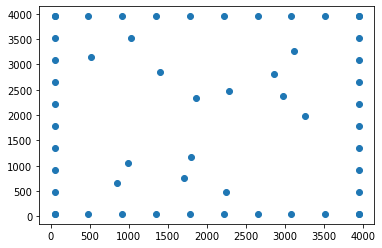

531.3207133483887


In [68]:
init_preprocessing(7)
# locs0 = rand_init_turb14()
locs1 = locs0.copy()
plot_turbine_locations(locs1);print(AEP_simp(np.array(locs1)));#to_csv(locs1,'iter_turb1.csv')

In [64]:
def sim_anneal1(locs,curr_temp=1,min_temp=1e-6,gamma=0.9,n_free=50,
                move_params = (10,3000,50), angle_params = (36,0)):
    preprocessed = preAEP(locs)
    curr_AEP     = AEP_simp(locs)
    best_AEP     = curr_AEP
    best_locs    = locs.copy()
    
    C, Nt, Ns    = 2, 1, 1
    # step_size = np.ones(50)*init_step_size
    # accepted  = np.zeros(50)
    locs_hist = [[locs.copy(),curr_AEP,-1]]

    while curr_temp >= min_temp:
        curr_temp *= gamma
        print('current_temp',curr_temp)
        for sub_iter_cnt in range(Nt):
            for s_ind in range(Ns):
                order  = np.arange(50 - n_free, 50)
                np.random.shuffle(order)
                for index in order:
                    locs_tmp  = locs.copy()
                    maxx_position, init_position = move1(locs_tmp,index,
                                            *move_params,*angle_params)  

                    # preprocessed_copy = [i.copy() for i in preprocessed]
                    new_AEP   = maxx_position[0]
                    delta_AEP = new_AEP - curr_AEP
                    # print(delta_AEP)
                        
                    if delta_AEP >= 0 or np.random.rand() < np.exp(delta_AEP/curr_temp):
                        locs[index][0],locs[index][1] = maxx_position[1], maxx_position[2]
                        locs_hist.append([index,maxx_position[1:],new_AEP,int(delta_AEP >= 0)])
                        curr_AEP = maxx_position[0]
                        # accepted[index] += 1

                        if best_AEP < new_AEP:
                            best_AEP           = maxx_position[0]
                            locs_tmp[index][0] = maxx_position[1]
                            locs_tmp[index][1] = maxx_position[2]
                            best_locs          = locs_tmp# careful don't change locs_tmp later
                            
                            # best_AEP           = AEP_simp(locs_tmp)
                            print(best_AEP,AEP_simp(locs_tmp), new_AEP)
                    else:
                        locs[index][0],locs[index][1] = init_position[1], init_position[2]
                    
                    print(index,curr_AEP)
    return best_locs,best_AEP,locs_hist#,step_size

In [ ]:
# locs_sa1 = locs1.copy()
locs_sa1 = best_locs.copy()

best_locs,best_AEP,locs_hist =  sim_anneal1(locs_sa1,n_free=14,
                                curr_temp=1,min_temp=1e-3,gamma=0.8,
                                move_params = (10,3000,25),
                                angle_params = (36,0))

# best_locs,best_AEP,locs_hist =  sim_anneal1(locs_sa1,n_free=50,
#                                 curr_temp=0.5,min_temp=1e-2,gamma=0.8,
#                                 move_params = (10,3000,50),
#                                 angle_params = (36,0))

current_temp 0.8
39 538.1570782470703
46 538.0918153381348
47 538.0651821899414
44 538.0628430175781
36 538.0778137207031
43 538.039919128418
48 537.9815400695801
37 537.8999029541015
40 537.7885917663574
42 537.8134872436524
45 537.8016911315918
41 537.7193188476563
49 537.7237298583984
38 537.587222442627
current_temp 0.6400000000000001
42 537.5678073120117
38 537.7056848144531
41 537.7841473388672
48 537.8300285339355
40 537.8734034729003
47 537.9058177185059
44 537.9101953125
39 537.8733032226562
45 537.8811561584473
46 537.9452160644531
37 537.9969451904296
49 538.0970617675781
36 538.0947894287109
43 538.13552444458
current_temp 0.5120000000000001
38 538.0350736999512
44 538.0303619384765
49 537.9732192993164
40 537.8803207397461
37 537.8031280517578
46 537.8029943847656
39 537.8444979858399
36 537.851047668457
47 537.8461019897461
41 537.7676394653321
42 537.7357933044434
48 537.7026438903808
45 537.6896447753907
43 537.6879071044922
current_temp 0.40960000000000013
46 537.68827

In [ ]:
to_csv(best_locs,'best_locs_hybrid_rand14_o16_v4.csv')
# to_csv(locs_sa1,'best_locs_hybrid_rand14_o16_v3.csv')

In [ ]:
init_preprocessing(7)
plot_turbine_locations(best_locs);print(AEP_simp(np.array(best_locs)));#to_csv(locs1,'iter_turb1.csv')
plot_turbine_locations(locs_sa1); print(AEP_simp(np.array(locs_sa1)));#to_csv(locs1,'iter_turb1.csv')

In [ ]:
AEPs = [i[2] for i in locs_hist[1:]]
# print(max(AEPs),best_AEP,AEP_simp(best_locs),sorted(AEPs,reverse=1)[:10])

In [ ]:
plt.plot(AEPs)

In [ ]:
def sim_anneal(locs,init_step_size=100,step_size_decay=1,curr_temp=1,min_temp=1e-6,gamma=0.9,n_free=50):
    preprocessed = preAEP(locs)
    curr_AEP  = AEP_simp(locs)
    best_AEP  = curr_AEP
    best_locs = locs.copy()
    C = 2

    Nt, Ns    = 1, 4
    step_size = np.ones(50)*init_step_size
    accepted  = np.zeros(50)

    locs_hist = [[locs.copy(),curr_AEP,-1]]

    while curr_temp >= min_temp:
        curr_temp *= gamma
        for sub_iter_cnt in range(Nt):
            for s_ind in range(Ns):
                for index in range(50 - n_free, 50):
                    while True:
                        point     = locs[index] + step_size[index]*(2*np.random.rand(2)-1)
                        if not ( check_inc_violation(locs[:index],point) or \
                        check_inc_violation(locs[index+1:],point)  ):
                            break
                        
                    # print(point)
                    # print([i.shape for i in preprocessed])
                    preprocessed_copy = [i.copy() for i in preprocessed]

                    new_AEP   = AEP_fast(index,point,*preprocessed)
                    # tmp = locs.copy()
                    # tmp[index] = point
                    # new_AEP   = AEP_simp(tmp)
                    delta_AEP = new_AEP - curr_AEP
                    if best_AEP < new_AEP:
                        locs_tmp = locs.copy()
                        locs_tmp[index][0] = point[0]
                        locs_tmp[index][1] = point[1]

                        new_AEP_tmp = AEP_simp(locs_tmp)
                        print(best_AEP,new_AEP,new_AEP_tmp)
                        if best_AEP < new_AEP_tmp:
                            best_AEP  = new_AEP_tmp
                            best_locs = locs_tmp
                            
                        # best_AEP  = new_AEP
                        # best_locs = locs.copy()
                        # best_locs[index] = point.copy()
                        
                    if delta_AEP >= 0 or np.random.rand() < np.exp(delta_AEP/curr_temp):
                        locs[index] = point
                        locs_hist.append([index,point,new_AEP,int(delta_AEP >= 0)])
                        curr_AEP = new_AEP
                        accepted[index] += 1
                        # print(curr_AEP)
                    else:
                        # preprocessed = preprocessed_copy
                        preprocessed = preAEP(locs)
            print(curr_AEP)
            mask_high = accepted > 0.6*Ns
            mask_low  = accepted < 0.4*Ns
            mask_mid  = 1 - (mask_high + mask_low)
            if step_size_decay>0:
                step_size = step_size*step_size_decay*  \
                            (mask_high*(1 + C*(accepted/Ns - 0.6)/0.4)
                            + mask_low/(1 + C*(0.4 - accepted/Ns)/0.4) 
                            + mask_mid)
            accepted[:] = 0
    return best_locs,best_AEP,locs_hist,step_size

In [ ]:
# locs0 = getTurbLoc('548.9.csv')
# to_csv(best_locs, 'sa536.csv')

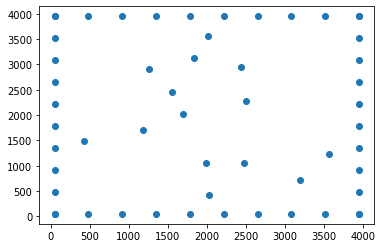

531.5011972045899


In [ ]:
# locs0 = rand_init_turb14()
init_preprocessing(7)
locs1 = locs0.copy()
plot_turbine_locations(locs1);print(AEP_simp(np.array(locs1)));#to_csv(locs1,'iter_turb1.csv')

In [ ]:
# locs_sa = locs1
locs_sa = best_locs.copy()
best_locs,best_AEP,locs_hist,*misc = sim_anneal(locs_sa,init_step_size=3000,
                                                step_size_decay = 3,
                                                curr_temp=0.07,gamma=0.92,min_temp=3e-3,
                                                n_free = 14)

In [ ]:
step_size = misc[0]
step_size

In [ ]:
# to_csv(best_locs,'549v1.csv')       

In [34]:
AEPs = [i[2] for i in locs_hist[1:]]
print(max(AEPs),best_AEP,AEP_simp(best_locs),sorted(AEPs,reverse=1)[:10])

536.718955078125 536.718955078125 536.718955078125 [536.718955078125, 536.7162817382813, 536.6293981933594, 536.5854885864258, 536.5830157470704, 536.5055557250977, 536.4931581115723, 536.4853051757813, 536.4760821533204, 536.4714038085938]


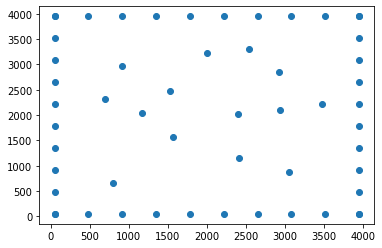

536.718955078125


In [35]:
# plot_turbine_locations(locs1);print(AEP_simp(np.array(locs1)));#to_csv(locs1,'iter_turb1.csv')
# plot_turbine_locations(best_locs);print(AEP_simp(np.array(best_locs)))
plot_turbine_locations(best_locs);print(AEP_simp(best_locs))